# Loading Data

In [ ]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# To get content
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pandas data
LeagueGames = pd.read_csv("/content/drive/MyDrive/high_diamond_ranked_10min.csv")

LeagueGames.head()
LeagueGames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

# Visualizing

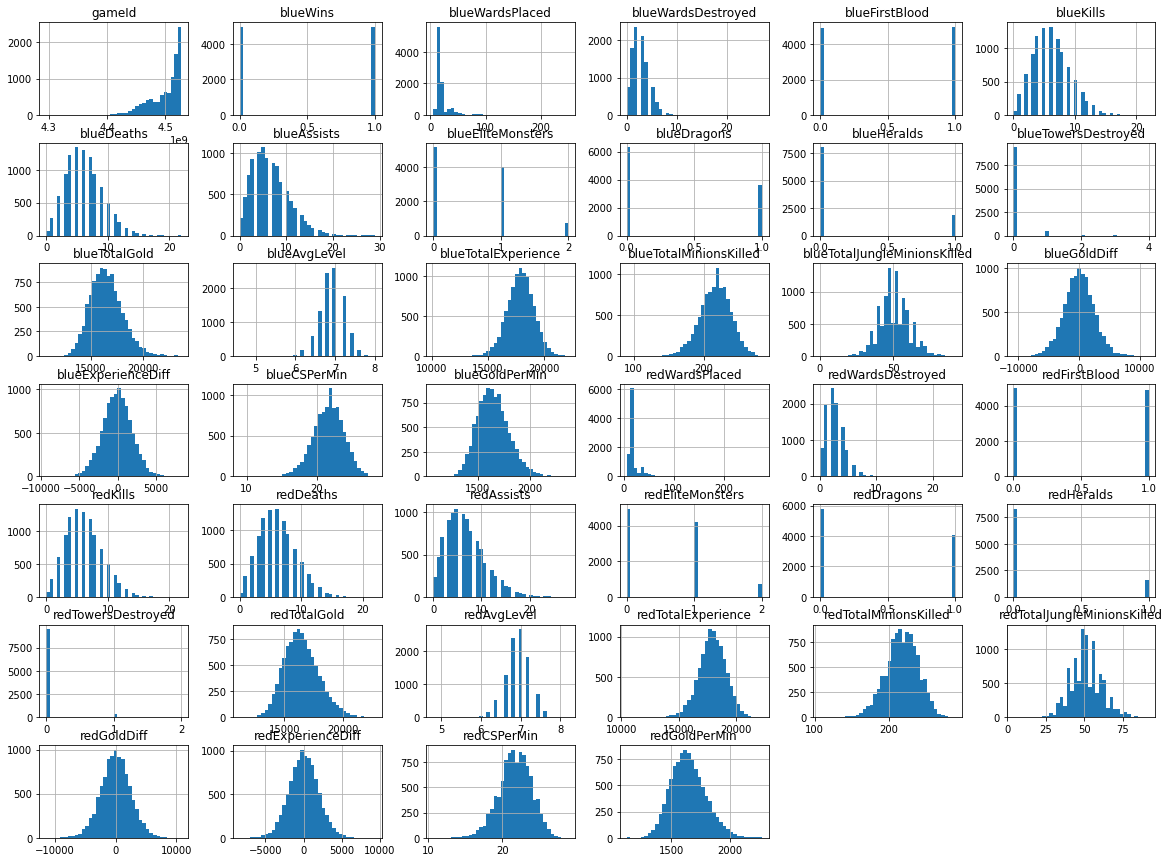

In [ ]:
#Histograms
LeagueGames.hist(bins=38, figsize=(20,15))
plt.show()

(0.0, 20.0, 0.0, 20.0)

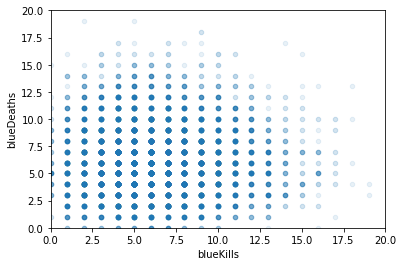

In [ ]:
#Scatter graph of blue kills and blue deaths
LeagueGames.plot(kind="scatter", x='blueKills', y='blueDeaths', alpha=0.1)
plt.axis([0, 20, 0, 20])

(0.0, 20.0, 5.0, 10.0)

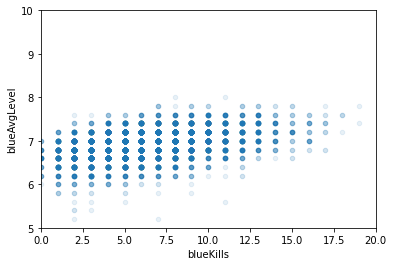

In [ ]:
#Scatter graph of blue kills and blue avg level
LeagueGames.plot(kind="scatter", x='blueKills', y='blueAvgLevel', alpha=0.1)
plt.axis([0, 20, 5, 10])

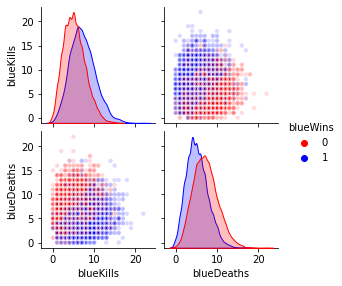

<Figure size 1080x1440 with 0 Axes>

In [ ]:
#Plot of blue kills, blue deaths to blue wins
LeagueJitter = LeagueGames[['blueKills','blueDeaths','blueWins']].copy()

LeagueJitter[['blueKills','blueDeaths']]

ax = sns.pairplot(LeagueJitter,hue="blueWins",height=2,plot_kws=dict(s=20,alpha=0.15,linewidth=2),palette=['red', 'blue'])

plt.figure(figsize=(15,20))
plt.show()

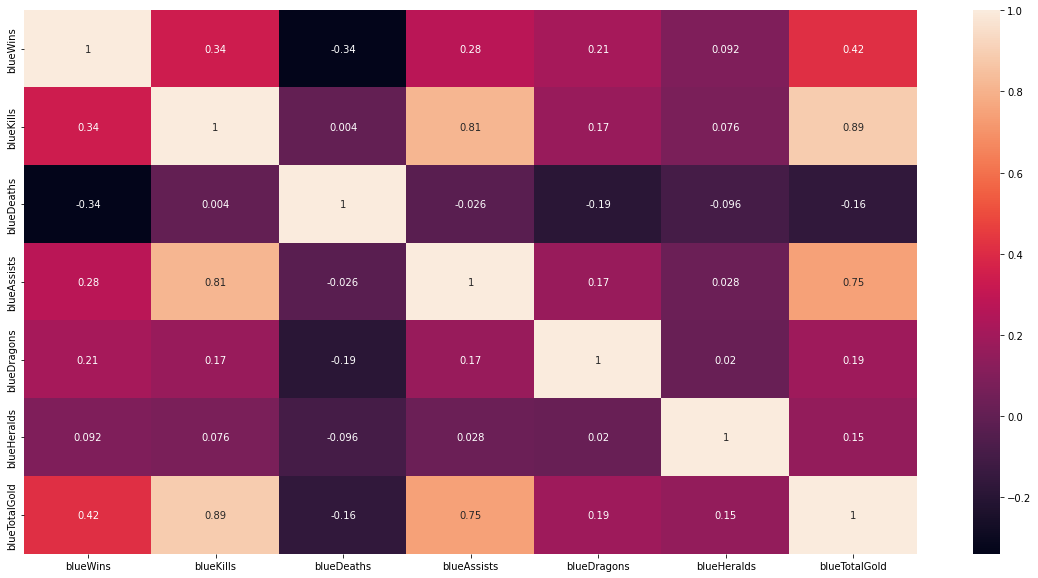

In [ ]:
# Correlation Matrix
cor = LeagueGames[['blueWins','blueKills', 'blueDeaths', 'blueAssists', 'blueDragons', 'blueHeralds', 'blueTotalGold']].corr()

plt.figure(figsize=(20,10))
sns.heatmap(cor, annot=True)
plt.show()

#Preprocessing

In [ ]:
# blue new KD diff
LeagueGames['blueKDDiff'] = LeagueGames['blueKills'] - LeagueGames['redKills']

# blue CS overall diff
LeagueGames['blueCSDiff'] = (LeagueGames['blueTotalMinionsKilled'] + LeagueGames['blueTotalJungleMinionsKilled']) - (LeagueGames['redTotalMinionsKilled'] + LeagueGames['redTotalJungleMinionsKilled'])

# blue vision score
LeagueGames['blueVisionScore'] = (LeagueGames['blueWardsPlaced'] + LeagueGames['blueWardsDestroyed'] - 0) - (LeagueGames['redWardsPlaced'] + LeagueGames['redWardsDestroyed'])


In [ ]:
#Drop unneeded
LeagueGames.drop(['redExperienceDiff', 'redGoldDiff', 'redDeaths', 'blueDeaths', 'redFirstBlood', 'blueTotalExperience' , 'redTotalExperience','redTotalGold' , 'blueTotalGold', 'gameId'] , axis = 1, inplace = True)

In [ ]:
# Remove Outliers
for column in [LeagueGames.columns]:

    mean = LeagueGames[column].mean()
    std = LeagueGames[column].std()
    threshold = std * 3

    lower =  mean - threshold
    upper =  mean + threshold

    LeagueGames = LeagueGames[(LeagueGames[column]) >= lower]
    LeagueGames = LeagueGames[(LeagueGames[column]) <= upper]

In [ ]:
# Scaling
noScalingLeagueGames = LeagueGames.copy()
LeagueGamesTemp = LeagueGames

scaler = StandardScaler()
scaledLeague = pd.DataFrame(scaler.fit_transform(LeagueGames.drop('blueWins', axis = 1)), 
                       columns = LeagueGames.drop('blueWins', axis = 1).columns)

LeagueGames = scaledLeague
LeagueGames['blueWins'] = LeagueGamesTemp['blueWins']

In [ ]:
# remove problematic
LeagueGames.dropna()
LeagueGames=LeagueGames[~LeagueGames.isin([np.nan, np.inf, -np.inf]).any(1)]

noScalingLeagueGames.dropna()
noScalingLeagueGames=noScalingLeagueGames[~noScalingLeagueGames.isin([np.nan, np.inf, -np.inf]).any(1)]
LeagueGames.head()

,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueAvgLevel,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redKills,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueKDDiff,blueCSDiff,blueVisionScore,blueWins
0,0.771759,-0.403783,0.990429,0.981639,1.179680,-0.879231,-0.753226,-0.481132,0.0,-1.107310,-1.021566,-1.502013,0.268450,0.017274,-1.021566,0.495919,-0.471680,2.068817,-0.025833,0.386678,-0.914893,-0.838966,-0.436495,0.0,-0.463430,-0.966386,0.380880,-0.966386,0.068317,0.714735,-0.575258,0.474476,0
2,-0.467629,-1.588385,-1.009663,0.297419,-0.657568,0.719503,1.327623,-0.481132,0.0,-1.792785,-1.440911,-0.466864,-0.490373,-0.530403,-1.440911,-0.243618,-0.471680,0.252054,1.739648,1.955795,-0.914893,-0.838966,-0.436495,0.0,-0.463430,-0.685567,-2.375479,-0.685567,0.563252,-0.980461,0.070994,-0.167583,0
3,2.201822,-0.996084,-1.009663,-0.728912,-0.395104,0.719503,-0.753226,2.078430,0.0,0.263639,-0.742002,0.464770,-0.552667,0.017809,-0.742002,-0.888100,-0.471680,-0.353533,-0.378929,0.909717,-0.914893,-0.838966,-0.436495,0.0,0.229345,0.812136,-0.435819,0.812136,0.006967,-0.253949,-0.722134,1.437564,0
4,5.252623,0.780818,-1.009663,-0.044691,-0.132640,-0.879231,-0.753226,-0.481132,0.0,0.263639,-0.322656,0.671800,-0.420135,0.144442,-0.322656,-0.050138,-0.288790,-0.353533,-0.025833,0.125158,0.681403,1.191944,-0.436495,0.0,0.229345,0.344104,1.605929,0.344104,0.645282,-0.011778,-0.692759,3.203227,0
5,-0.181616,-1.588385,-1.009663,-0.386801,-0.132640,0.719503,1.327623,-0.481132,0.0,0.263639,0.376253,-0.880923,0.291445,0.075515,0.376253,-0.387885,1.448665,1.463229,-1.085121,-1.182440,-0.914893,-0.838966,-0.436495,0.0,0.229345,0.156891,0.789230,0.156891,-0.873301,0.472564,-0.340257,-1.237682,1


# Metrics

In [ ]:
# Define print metrics for a model
#Used to print ROC curve and confusion matrix
def printMetrics(model,X_test, y_test, y_pred):
  cr=classification_report(y_test, y_pred)
  
  cm=confusion_matrix(y_test, y_pred)
  TP = cm[0][0]
  FN = cm[0][1]
  FP = cm[1][0]
  TN = cm[1][1]

  naive_probs = model.predict_proba(X_test)
  naive_probs = naive_probs[:,0]
  roc_auc = roc_auc_score(y_test, naive_probs)

  naive_tpr, naive_fpr, _ = roc_curve(y_test, naive_probs)


  print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))
  print()
  print(cr)
  print()
  print("True Positive: %d | False Negative: %d | False Positive: %d | True Negative: %d"% (TP, FN, FP, TN))
  print()
  print("AUROC: %f"% (roc_auc))
  print()
  plt.plot(naive_fpr, naive_tpr)
  plt.title("ROC Plot")
  plt.xlabel("False Positive")
  plt.ylabel("True Positive")
  print("____________________________________________________________________________________________")


In [ ]:
#Return AUROC
def returnAUROC(model, data):

  x = gaussianBayes(data)


  model = x[0]
  X_test = x[1]
  y_test = x[2]
  y_pred = x[3]

  cr=classification_report(y_test, y_pred)
  
  cm=confusion_matrix(y_test, y_pred)
  TP = cm[0][0]
  FN = cm[0][1]
  FP = cm[1][0]
  TN = cm[1][1]

  naive_probs = model.predict_proba(X_test)
  naive_probs = naive_probs[:,1]
  roc_auc = roc_auc_score(y_test, naive_probs)

  return roc_auc

# Naive Bayes

In [ ]:
# Define gaussian bayes function

def gaussianBayes(data):
  model = GaussianNB()
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
  gaussianModel = model.fit(X_train, y_train)
  y_pred = model.fit(X_train, y_train).predict(X_test)
  

  return [gaussianModel,X_test, y_test, y_pred]

In [ ]:
# do gaussian bayes and show how well it is

def displayGaussianBayes(data):
  x = gaussianBayes(data)
  printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1159

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1997
           1       0.71      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1422 | False Negative: 575 | False Positive: 584 | True Negative: 1414

AUROC: 0.207056

____________________________________________________________________________________________


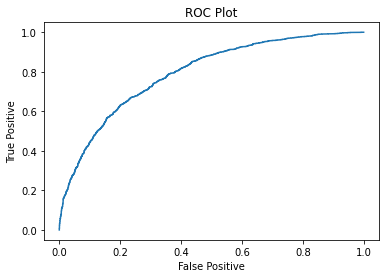

In [ ]:
displayGaussianBayes(LeagueGames)

# Feature Selection Implementation

In [ ]:
# Define number of features to be tested ~ 2 classes * 2 * 5 * 10

featureNumber = [4, 10, 30]


def featureExtractionTest(data,modelTested,featureExtractor):
  for x in featureNumber:
    print("Number of features: %d"% x)
    print(modelTested(featureExtractor(data, x)))

Number of mislabeled points out of a total 3995 points : 1159

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1997
           1       0.71      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1422 | False Negative: 575 | False Positive: 584 | True Negative: 1414

AUROC: 0.207056

____________________________________________________________________________________________


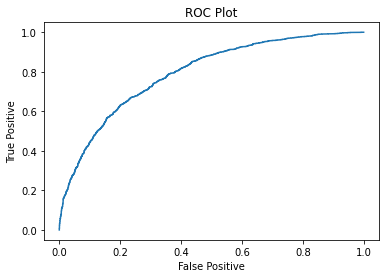

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Variance Threshold feature selection

def varianceThreshold(data):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  select = VarianceThreshold(threshold = 0)
  x = select.fit(X)

  constant = [column for column in X.columns if column not in X.columns[x.get_support()]]
  newLeague = data.drop(constant, axis = 1)
  return newLeague

displayGaussianBayes(varianceThreshold(LeagueGames))

In [ ]:
#from sklearn.feature_selection import SelectKBest, f_classif

# f_classification to get best features

#def fClass(data, k):

 # X = data.drop('blueWins', 1)
 # Y = data['blueWins']
  
  #select = SelectKBest(f_classif, k)
  #x = select.fit(X, Y)
  #constant = [column for column in X.columns if column not in X.columns[x.get_support()]]
  #newLeague = data.drop(constant, axis = 1)
  
  #return newLeague

#featureExtractionTest(LeagueGames,displayGaussianBayes, fClass)

Number of features: 4
Number of mislabeled points out of a total 3995 points : 1146

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1997
           1       0.71      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1426 | False Negative: 571 | False Positive: 575 | True Negative: 1423

AUROC: 0.212382

____________________________________________________________________________________________
None
Number of features: 10
Number of mislabeled points out of a total 3995 points : 1146

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1997
           1       0.71      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71    

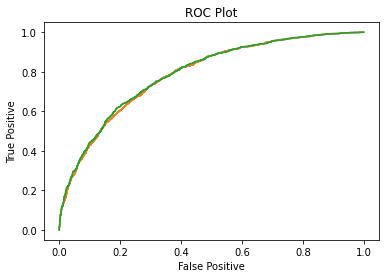

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#random forest classification 
#feature selection using randmfores
def randomForest(data, k):

  X = data.drop('blueWins', 1)
  y = data['blueWins']
  
  rfc = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=1, max_features= k))
  rfc.fit(X, y)
  
  remove = [column for column in X.columns if column not in X.columns[rfc.get_support()]]

  new = data.drop(remove, axis = 1)
 
  return new

featureExtractionTest(LeagueGames,displayGaussianBayes, randomForest)

Number of mislabeled points out of a total 3995 points : 1193

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1997
           1       0.71      0.69      0.70      1998

    accuracy                           0.70      3995
   macro avg       0.70      0.70      0.70      3995
weighted avg       0.70      0.70      0.70      3995


True Positive: 1431 | False Negative: 566 | False Positive: 627 | True Negative: 1371

AUROC: 0.226340

____________________________________________________________________________________________


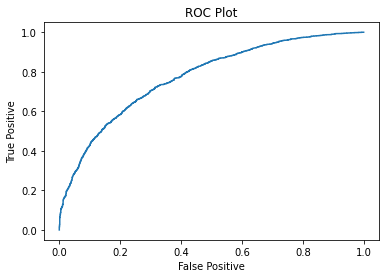

In [ ]:
# Based on matrix
coorelationD = LeagueGames[['blueWins', 'blueGoldDiff', 'blueDragons', 'blueKills']]

displayGaussianBayes(coorelationD)

Number of features: 4
Number of mislabeled points out of a total 3995 points : 1139

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1997
           1       0.72      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1432 | False Negative: 565 | False Positive: 574 | True Negative: 1424

AUROC: 0.205385

____________________________________________________________________________________________
None
Number of features: 10
Number of mislabeled points out of a total 3995 points : 1161

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1997
           1       0.71      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71    

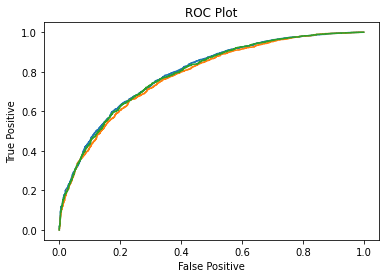

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC

# Linear SVC Implementation to get features

def linearSVC(data, k):

  X = data.drop('blueWins', 1)
  y = data['blueWins']
  
  lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
  selector = SelectFromModel(lsvc, max_features = k)
  selector = selector.fit(X, y)
  
  remove = [column for column in X.columns if column not in X.columns[selector.get_support()]]

  new = data.drop(remove, axis = 1)
 
  return new

featureExtractionTest(LeagueGames,displayGaussianBayes, linearSVC)  

Number of features: 4
Number of mislabeled points out of a total 3995 points : 1130

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1997
           1       0.71      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1407 | False Negative: 590 | False Positive: 540 | True Negative: 1458

AUROC: 0.208817

____________________________________________________________________________________________
None
Number of features: 10
Number of mislabeled points out of a total 3995 points : 1133

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      1997
           1       0.71      0.72      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72    

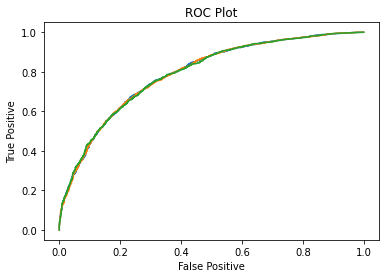

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Trees Classifier to get best features

def treesClassifier(data, k):

  X = data.drop('blueWins', 1)
  y = data['blueWins']
  
  clf = ExtraTreesClassifier(n_estimators=50, max_features = k)
  clf = clf.fit(X, y)
  selector = SelectFromModel(clf, prefit=True, max_features = k)

  remove = [column for column in X.columns if column not in X.columns[selector.get_support()]]

  new = data.drop(remove, axis = 1)

 
  return new

featureExtractionTest(LeagueGames,displayGaussianBayes, treesClassifier)

# Data Set Division based on Feature Extraction Implementation

In [ ]:
# This funciton will extract the best data set using the previous feature selection implementation

# All multiple round based methods. It will return ROC score for each number of features, for every way of method extraction.
methods = [linearSVC, treesClassifier, randomForest]
featureNumber = [4, 10, 30]

def getBestDatasets(data, methodlist, featurelist):
  dataSets = []

  for number in featurelist:
    bestdf = LeagueGames
    bestAUROC = 0
    for method in methodlist:
      dataset = method(data, number)
      auroc = returnAUROC(GaussianNB, dataset)
      if auroc > bestAUROC:
        bestAUROC = auroc
        bestdf = dataset
    dataSets.append(bestdf)
    
  return dataSets

Number of mislabeled points out of a total 3995 points : 1193

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1997
           1       0.71      0.69      0.70      1998

    accuracy                           0.70      3995
   macro avg       0.70      0.70      0.70      3995
weighted avg       0.70      0.70      0.70      3995


True Positive: 1431 | False Negative: 566 | False Positive: 627 | True Negative: 1371

AUROC: 0.226340

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1139

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1997
           1       0.72      0.71      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1432 |

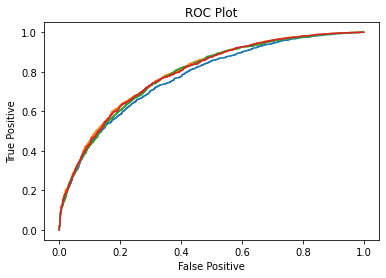

In [ ]:
# Divide our dataset

leagueFourFeatures, leagueTenFeatures, leagueThirtyFeatures = getBestDatasets(LeagueGames, methods, featureNumber)

displayGaussianBayes(coorelationD)
displayGaussianBayes(leagueFourFeatures)
displayGaussianBayes(leagueTenFeatures)
displayGaussianBayes(leagueThirtyFeatures)

In [ ]:
coorelationD.head()

,blueWins,blueGoldDiff,blueDragons,blueKills
0,0,0.268450,-0.753226,0.981639
2,0,-0.490373,1.327623,0.297419
3,0,-0.552667,-0.753226,-0.728912
4,0,-0.420135,-0.753226,-0.044691
5,1,0.291445,1.327623,-0.386801


In [ ]:
leagueFourFeatures.head()

,blueDragons,blueGoldDiff,blueExperienceDiff,redDragons,blueWins
0,-0.753226,0.268450,0.017274,-0.838966,0
2,1.327623,-0.490373,-0.530403,-0.838966,0
3,-0.753226,-0.552667,0.017809,-0.838966,0
4,-0.753226,-0.420135,0.144442,1.191944,0
5,1.327623,0.291445,0.075515,-0.838966,1


In [ ]:
leagueTenFeatures.head()

,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin,blueKDDiff,blueCSDiff,blueVisionScore,blueWins
0,-1.021566,-1.502013,0.268450,0.017274,-1.021566,0.495919,-0.966386,0.380880,-0.966386,0.068317,0.714735,-0.575258,0.474476,0
2,-1.440911,-0.466864,-0.490373,-0.530403,-1.440911,-0.243618,-0.685567,-2.375479,-0.685567,0.563252,-0.980461,0.070994,-0.167583,0
3,-0.742002,0.464770,-0.552667,0.017809,-0.742002,-0.888100,0.812136,-0.435819,0.812136,0.006967,-0.253949,-0.722134,1.437564,0
4,-0.322656,0.671800,-0.420135,0.144442,-0.322656,-0.050138,0.344104,1.605929,0.344104,0.645282,-0.011778,-0.692759,3.203227,0
5,0.376253,-0.880923,0.291445,0.075515,0.376253,-0.387885,0.156891,0.789230,0.156891,-0.873301,0.472564,-0.340257,-1.237682,1


In [ ]:
leagueThirtyFeatures.head()

,blueWardsPlaced,blueFirstBlood,blueEliteMonsters,blueDragons,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redEliteMonsters,redDragons,blueKDDiff,blueCSDiff,blueWins
0,0.771759,0.990429,-0.879231,-0.753226,-1.502013,0.268450,0.017274,-0.471680,2.068817,-0.914893,-0.838966,0.714735,-0.575258,0
2,-0.467629,-1.009663,0.719503,1.327623,-0.466864,-0.490373,-0.530403,-0.471680,0.252054,-0.914893,-0.838966,-0.980461,0.070994,0
3,2.201822,-1.009663,0.719503,-0.753226,0.464770,-0.552667,0.017809,-0.471680,-0.353533,-0.914893,-0.838966,-0.253949,-0.722134,0
4,5.252623,-1.009663,-0.879231,-0.753226,0.671800,-0.420135,0.144442,-0.288790,-0.353533,0.681403,1.191944,-0.011778,-0.692759,0
5,-0.181616,-1.009663,0.719503,1.327623,-0.880923,0.291445,0.075515,1.448665,1.463229,-0.914893,-0.838966,0.472564,-0.340257,1


# Clustering Visualization and Optimizing

In [ ]:
#This will help us plot the cluster
class Clusters():
    def __init__(self, cluster, data):
        self.cluster = cluster
        self.cluster_labels = cluster.labels_
        self.data = data.copy()
                
    def plot(self, xaxis, yaxis):
        fig = plt.plot(figsize = (11,9))
        
        self.data.insert(0, 'Clusters', self.cluster_labels)
        g = sns.scatterplot(data = self.data, x = xaxis, y = yaxis, hue = 'Clusters', alpha = 0.5, edgecolor = 'k', palette = 'viridis')

        plt.show()

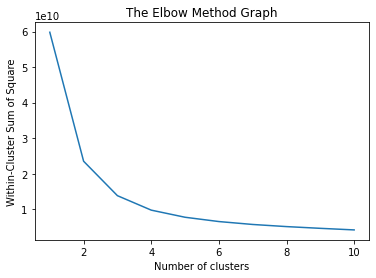

In [ ]:
#ELbow method to get best cluster k
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.cluster import KMeans

def bestCluster(data):
  kin=[]

  for i in range(1,11): 
     kmeans = KMeans(n_clusters=i, init ='k-means++', n_init=10, random_state=0 )
     kmeans.fit(data)
     kin.append(kmeans.inertia_)

  plt.plot(range(1,11),kin)
  plt.title('The Elbow Method Graph')
  plt.xlabel('Number of clusters')
  plt.ylabel('Within-Cluster Sum of Square')
  plt.show()

bestCluster(noScalingLeagueGames)

In [ ]:
from sklearn import metrics

In [ ]:
def rand(t,f):
  print('Rand:', metrics.adjusted_rand_score(t, f))

In [ ]:
#Fowlkes Mallows Score
def mallows(t,f):
  print('Fowlkes Mallows:', metrics.fowlkes_mallows_score(t, f))

In [ ]:
#MutualInformation Score
def mutualInfo(t,f):
  print('Mutual Information: ', metrics.adjusted_mutual_info_score(t, f))

In [ ]:
#Homogenity
def homo(t,f):
  print('Homogenity: ', metrics.homogeneity_score(t, f))

In [ ]:
#Completeness
def completeness(t,f):
  print('Complete: ', metrics.completeness_score(t, f))

In [ ]:
#CalinskiHarabasz
def calinskiHarabasz(X,labels):
  print('Harabasz:',metrics.calinski_harabasz_score(X, labels))

In [ ]:
#Silhouette
def silhouette(X,labels):
  print('Silhouette: ', metrics.silhouette_score(X, labels, metric='euclidean'))

# KMeans Clustering

In [ ]:
#k means clustering
def kMeansClustering(data, k):

  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  kmeans_model = KMeans(n_clusters=k, random_state=42).fit(X)
  predlabels = kmeans_model.labels_
  return [data, Y, predlabels]

k = kMeansClustering(noScalingLeagueGames, 2)

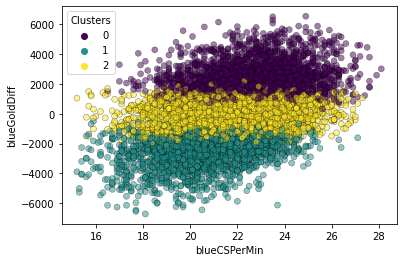

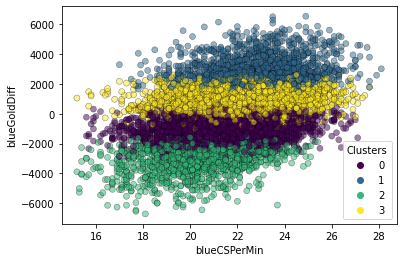

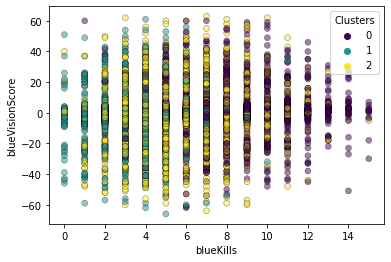

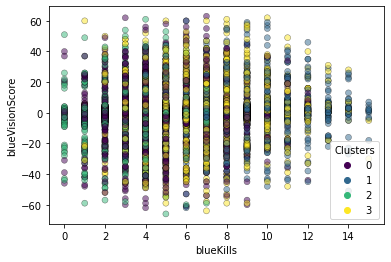

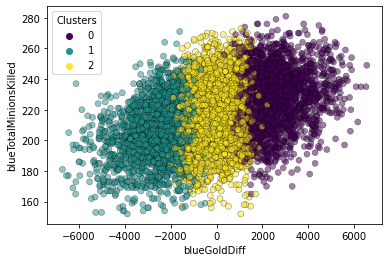

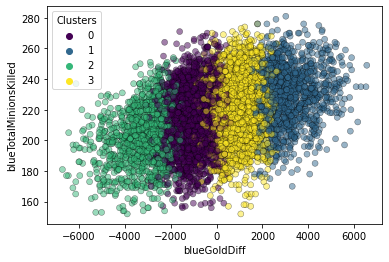

In [ ]:
#Visualize cluster
def visualizeKMeansClustering(k, xaxis, yaxis):
  leagueCopy = noScalingLeagueGames.copy()

  kmeans= KMeans(n_clusters = k, random_state = 42).fit(leagueCopy.values)
  clusterp = Clusters(kmeans, leagueCopy)
  clusterp.plot(xaxis, yaxis)

visualizeKMeansClustering(3,'blueCSPerMin', 'blueGoldDiff')
visualizeKMeansClustering(4,'blueCSPerMin', 'blueGoldDiff')

visualizeKMeansClustering(3,'blueKills', 'blueVisionScore')
visualizeKMeansClustering(4,'blueKills', 'blueVisionScore')

visualizeKMeansClustering(3,'blueGoldDiff', 'blueTotalMinionsKilled')
visualizeKMeansClustering(4,'blueGoldDiff', 'blueTotalMinionsKilled')

In [ ]:
#Accuracy of cluster
print('Two Clusters')
k = kMeansClustering(noScalingLeagueGames, 2)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\nThree Clusters')
k = kMeansClustering(noScalingLeagueGames, 3)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\nFour Clusters')
k = kMeansClustering(noScalingLeagueGames, 4)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\nFive Clusters')
k = kMeansClustering(noScalingLeagueGames, 5)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

Two Clusters
Rand: 0.1887262292044521
Fowlkes Mallows: 0.5943200294060991
Mutual Information:  0.1408005488286717
Homogenity:  0.1408769784155836
Complete:  0.14087928978772005
Harabasz: 2398.337213625851
Silhouette:  0.1621656348687402

Three Clusters
Rand: 0.12080298490602266
Fowlkes Mallows: 0.49316199515231296
Mutual Information:  0.13563883470819557
Homogenity:  0.17236111282565858
Complete:  0.11198318835102239
Harabasz: 2398.337213625851
Silhouette:  0.1621656348687402

Four Clusters
Rand: 0.09679617629339594
Fowlkes Mallows: 0.43706866905080943
Mutual Information:  0.12612777457201424
Homogenity:  0.18443074475521046
Complete:  0.09602007019249557
Harabasz: 2398.337213625851
Silhouette:  0.1621656348687402

Five Clusters
Rand: 0.08084113332636132
Fowlkes Mallows: 0.3958528141077953
Mutual Information:  0.11800024146636928
Homogenity:  0.19055890529726424
Complete:  0.08566738264262358
Harabasz: 2398.337213625851
Silhouette:  0.1621656348687402


# Mean Shift

In [ ]:
#Mean shift clustering
from sklearn.cluster import MeanShift

def meanShiftClustering(data):
  X = data.drop('blueWins', 1)
  y = data['blueWins']
  k = sklearn.cluster.estimate_bandwidth(X,random_state=42)

  meanshift = MeanShift(bandwidth = k).fit(X)
  predict = meanshift.labels_

  return [X,y,predict]

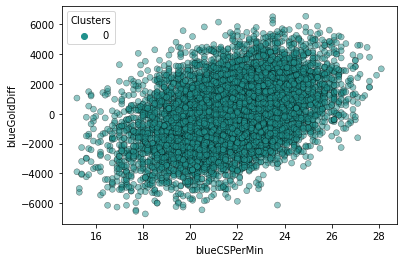

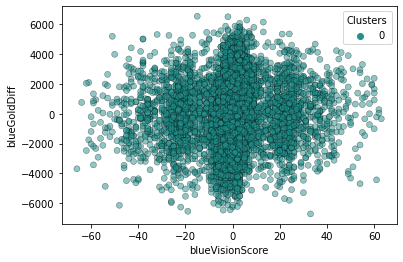

In [ ]:
#Visualize cluster
def visualizeMeanShiftClustering(xaxis, yaxis):
  leagueCopy = noScalingLeagueGames.copy()
  k = sklearn.cluster.estimate_bandwidth(leagueCopy.drop('blueWins',1),random_state=42)
  meanShift = MeanShift(bandwidth = k).fit(leagueCopy.values)
  MSc = Clusters(meanShift, leagueCopy)
  MSc.plot(xaxis, yaxis)


visualizeMeanShiftClustering('blueCSPerMin', 'blueGoldDiff')

visualizeMeanShiftClustering('blueVisionScore', 'blueGoldDiff')

In [ ]:
#Accuracy of cluster
k = meanShiftClustering(noScalingLeagueGames)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

Rand: 0.0
Fowlkes Mallows: 0.707065205719773
Mutual Information:  -2.5627552184043205e-15
Homogenity:  -1.2813776092021602e-15
Complete:  1.0
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698


# Affinity Propagation

In [ ]:
#Affinity propagation
from sklearn.cluster import AffinityPropagation

def affinityPropagationClustering(data,e):

  X = data.drop('blueWins', 1)
  y = data['blueWins']

  affinityprop = AffinityPropagation(damping=e,max_iter = 200)
  y_affp = affinityprop.fit_predict(X,y)
  
  return [X, y, y_affp]

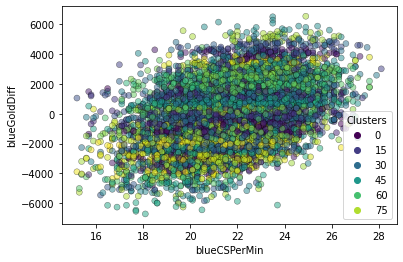

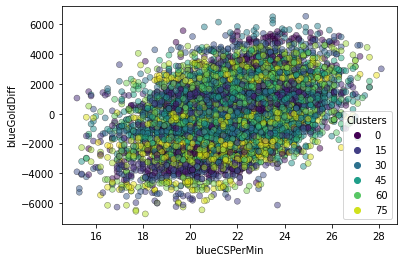

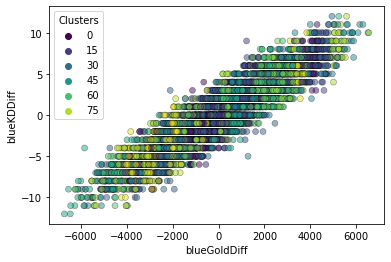

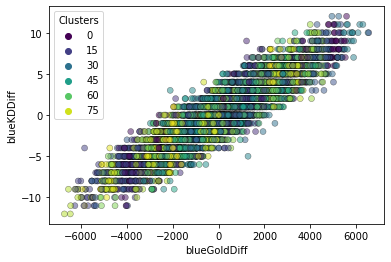

In [ ]:
#Visualize cluster
def visualizeAPCClustering(xaxis, yaxis,e):
  leagueCopy = noScalingLeagueGames.copy()

  app = AffinityPropagation(damping=e,max_iter=200).fit(leagueCopy.values)
  
  apfcluster = Clusters(app, leagueCopy)
  apfcluster.plot(xaxis, yaxis)

visualizeAPCClustering('blueCSPerMin','blueGoldDiff',0.52)
visualizeAPCClustering('blueCSPerMin','blueGoldDiff',0.75)

visualizeAPCClustering('blueGoldDiff','blueKDDiff',0.52)
visualizeAPCClustering('blueGoldDiff','blueKDDiff',0.75)

In [ ]:
print('50% damping')
k = affinityPropagationClustering(noScalingLeagueGames, 0.5)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\n60% damping')
k = affinityPropagationClustering(noScalingLeagueGames, 0.6)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\n70% damping')
k = affinityPropagationClustering(noScalingLeagueGames, 0.7)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\n80% damping')
k = affinityPropagationClustering(noScalingLeagueGames, 0.8)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

50% damping


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


Rand: 0.0
Fowlkes Mallows: 0.707065205719773
Mutual Information:  -2.5627552184043205e-15
Homogenity:  -1.2813776092021602e-15
Complete:  1.0
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698

60% damping
Rand: 0.005474982517748131
Fowlkes Mallows: 0.10155211205086212
Mutual Information:  0.055979015995973165
Homogenity:  0.20916545080076565
Complete:  0.033654353177903946
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698

70% damping
Rand: 0.0055786619257669635
Fowlkes Mallows: 0.10206399115031715
Mutual Information:  0.056036749406578684
Homogenity:  0.20847933559502632
Complete:  0.033666053254124605
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698

80% damping
Rand: 0.0056782041097565026
Fowlkes Mallows: 0.10128830555752256
Mutual Information:  0.05616716391527881
Homogenity:  0.21021769694415093
Complete:  0.03373382422539591
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698


# Spectral Shift

In [ ]:
#Spectral Shift clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import SpectralClustering
def spectralCluster(data,k):

  X = data.drop('blueWins', 1)
  y = data['blueWins']

  spectralc = SpectralClustering(n_clusters = k, random_state = 42).fit(X)
  spectral_y = spectralc.labels_
  
  return [X, y, spectral_y]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


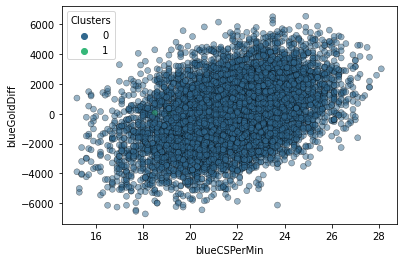

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


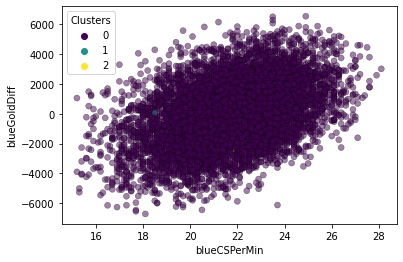

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


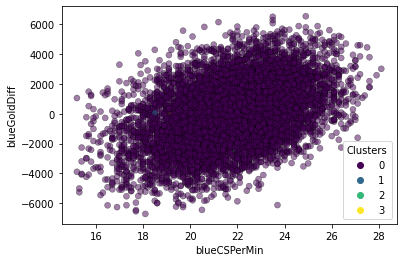

In [ ]:
#Visualize cluster
def visualizeSpecteralC(xaxis, yaxis, k):
  leagueCopy = noScalingLeagueGames.copy()

  spectra = SpectralClustering(n_clusters = k,random_state = 42).fit(leagueCopy.values)
  
  SCluster = Clusters(spectra, noScalingLeagueGames)
  SCluster.plot(xaxis,yaxis)

visualizeSpecteralC('blueCSPerMin','blueGoldDiff',2)
visualizeSpecteralC('blueCSPerMin','blueGoldDiff',3)
visualizeSpecteralC('blueCSPerMin','blueGoldDiff',4)

In [ ]:
#Accuracy of cluster
print('Two Clusters')
k = spectralCluster(noScalingLeagueGames, 2)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\nThree Clusters')
k = spectralCluster(noScalingLeagueGames, 3)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

print('\nFour Clusters')
k = spectralCluster(noScalingLeagueGames, 4)
rand(k[1],k[2])
mallows(k[1],k[2])
mutualInfo(k[1],k[2])
homo(k[1],k[2])
completeness(k[1],k[2])
calinskiHarabasz(k[0],k[1])
silhouette(k[0],k[1])

Two Clusters


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Rand: -2.6239893618432434e-06
Fowlkes Mallows: 0.706887290070504
Mutual Information:  0.000247636161355755
Homogenity:  0.00024936624431405753
Complete:  0.07430821803229608
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698

Three Clusters


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Rand: 1.524092216997697e-08
Fowlkes Mallows: 0.7067112360512983
Mutual Information:  0.0004975178890241152
Homogenity:  0.0005006312593423618
Complete:  0.07459212862130235
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698

Four Clusters


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:296: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


Rand: 1.524092216997697e-08
Fowlkes Mallows: 0.7067112360512983
Mutual Information:  0.0004975178890241152
Homogenity:  0.0005006312593423618
Complete:  0.07459212862130235
Harabasz: 2398.3368666455513
Silhouette:  0.16216556967364698


# J48 Decision Tree on Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier
#return the split
def returnTrainingTest(data,s):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=s, random_state=0)
  return [X_train, X_test, y_train, y_test]

Number of mislabeled points out of a total 3995 points : 0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1987
           1       1.00      1.00      1.00      2008

    accuracy                           1.00      3995
   macro avg       1.00      1.00      1.00      3995
weighted avg       1.00      1.00      1.00      3995


True Positive: 1987 | False Negative: 0 | False Positive: 0 | True Negative: 2008

AUROC: 0.000000

____________________________________________________________________________________________


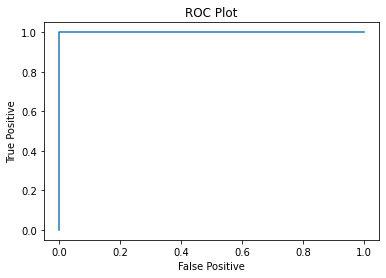

In [ ]:
from sklearn import tree
def J48Training(data,s,crit,split,maxD,maxF,minL,ccpa):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  
  tree_clf = DecisionTreeClassifier(criterion=crit, splitter=split,max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  treeFit = tree_clf.fit(X_train, y_train)
  y_pred = treeFit.predict(X_train)
  
  return [treeFit,X_train, y_train, y_pred]

#THIS is a default tree
x=J48Training(LeagueGames,0.5,"gini","best",None,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1100

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1987
           1       0.71      0.76      0.73      2008

    accuracy                           0.72      3995
   macro avg       0.73      0.72      0.72      3995
weighted avg       0.73      0.72      0.72      3995


True Positive: 1375 | False Negative: 612 | False Positive: 488 | True Negative: 1520

AUROC: 0.201020

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1126

              precision    recall  f1-score   support

           0       0.75      0.65      0.69      1987
           1       0.69      0.79      0.74      2008

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1282 |

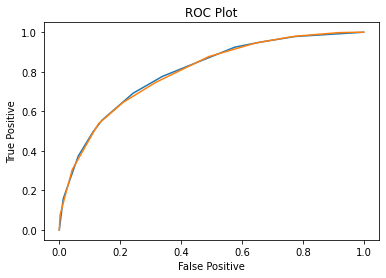

In [ ]:
#Criterion Test

x=J48Training(LeagueGames,0.5,"gini","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48Training(LeagueGames,0.5,"entropy","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1100

              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1987
           1       0.71      0.76      0.73      2008

    accuracy                           0.72      3995
   macro avg       0.73      0.72      0.72      3995
weighted avg       0.73      0.72      0.72      3995


True Positive: 1375 | False Negative: 612 | False Positive: 488 | True Negative: 1520

AUROC: 0.201020

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1197

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1987
           1       0.72      0.66      0.69      2008

    accuracy                           0.70      3995
   macro avg       0.70      0.70      0.70      3995
weighted avg       0.70      0.70      0.70      3995


True Positive: 1474 |

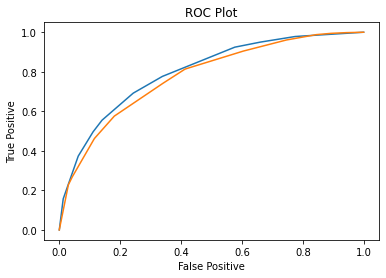

In [ ]:
x=J48Training(LeagueGames,0.5,"gini","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48Training(LeagueGames,0.5,"gini","random",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Depth: 2
Number of mislabeled points out of a total 3995 points : 1141

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1987
           1       0.73      0.68      0.71      2008

    accuracy                           0.71      3995
   macro avg       0.72      0.71      0.71      3995
weighted avg       0.72      0.71      0.71      3995


True Positive: 1483 | False Negative: 504 | False Positive: 637 | True Negative: 1371

AUROC: 0.227717

____________________________________________________________________________________________
Depth: 3
Number of mislabeled points out of a total 3995 points : 1127

              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1987
           1       0.70      0.78      0.74      2008

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


Tru

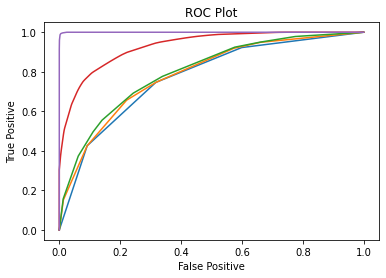

In [ ]:
#Max Depth
for x in range(2,5):
  print("Depth:",x)
  x=J48Training(LeagueGames,0.5,"gini","best",x,None,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

x=J48Training(LeagueGames,0.5,"gini","best",10,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48Training(LeagueGames,0.5,"gini","best",20,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1403

              precision    recall  f1-score   support

           0       0.61      0.80      0.69      1987
           1       0.72      0.50      0.59      2008

    accuracy                           0.65      3995
   macro avg       0.66      0.65      0.64      3995
weighted avg       0.66      0.65      0.64      3995


True Positive: 1589 | False Negative: 398 | False Positive: 1005 | True Negative: 1003

AUROC: 0.309400

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1332

              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1987
           1       0.78      0.47      0.59      2008

    accuracy                           0.67      3995
   macro avg       0.70      0.67      0.65      3995
weighted avg       0.70      0.67      0.65      399

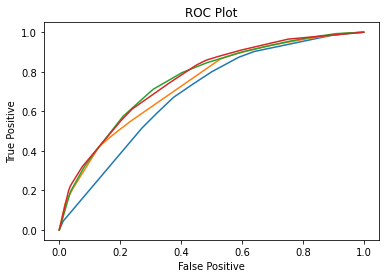

In [ ]:
#Max Features

for x in range(2,6):
  print("features:",x)
  x=J48Training(LeagueGames,0.5,"gini","best",2,x,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

Leaf: 2
Number of mislabeled points out of a total 3995 points : 1375

              precision    recall  f1-score   support

           0       0.74      0.48      0.58      1987
           1       0.62      0.83      0.71      2008

    accuracy                           0.66      3995
   macro avg       0.68      0.65      0.64      3995
weighted avg       0.68      0.66      0.64      3995


True Positive: 944 | False Negative: 1043 | False Positive: 332 | True Negative: 1676

AUROC: 0.294601

____________________________________________________________________________________________
Leaf: 3
Number of mislabeled points out of a total 3995 points : 1375

              precision    recall  f1-score   support

           0       0.74      0.48      0.58      1987
           1       0.62      0.83      0.71      2008

    accuracy                           0.66      3995
   macro avg       0.68      0.65      0.64      3995
weighted avg       0.68      0.66      0.64      3995


True 

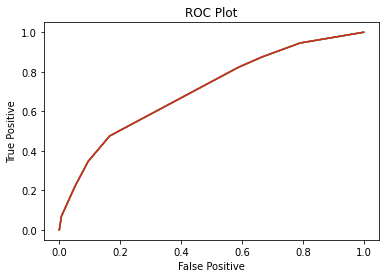

In [ ]:
#Min leaf

for x in range(2,6):
  print("Leaf:",x)
  x=J48Training(LeagueGames,0.5,"gini","best",3,3,x,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

ccp:  0.001
Number of mislabeled points out of a total 3995 points : 1333

              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1987
           1       0.78      0.47      0.59      2008

    accuracy                           0.67      3995
   macro avg       0.70      0.67      0.65      3995
weighted avg       0.70      0.67      0.65      3995


True Positive: 1720 | False Negative: 267 | False Positive: 1066 | True Negative: 942

AUROC: 0.264062

____________________________________________________________________________________________
ccp:  0.002
Number of mislabeled points out of a total 3995 points : 1333

              precision    recall  f1-score   support

           0       0.62      0.87      0.72      1987
           1       0.78      0.47      0.59      2008

    accuracy                           0.67      3995
   macro avg       0.70      0.67      0.65      3995
weighted avg       0.70      0.67      0.65      3995

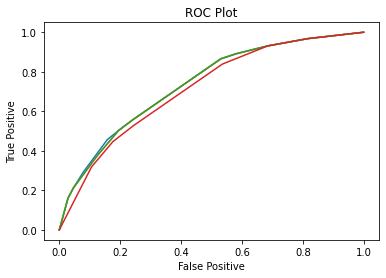

In [ ]:
#CCP Alpha
deez = [0.001,0.002,0.003,0.004]
for x in deez:
  print("ccp: ",x)
  x=J48Training(LeagueGames,0.5,"gini","best",4,3,6,x)
  printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 5593 points : 1971

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      2767
           1       0.63      0.73      0.68      2826

    accuracy                           0.65      5593
   macro avg       0.65      0.65      0.64      5593
weighted avg       0.65      0.65      0.65      5593


True Positive: 1560 | False Negative: 1207 | False Positive: 764 | True Negative: 2062

AUROC: 0.296371

____________________________________________________________________________________________
Number of mislabeled points out of a total 3196 points : 1121

              precision    recall  f1-score   support

           0       0.60      0.84      0.70      1582
           1       0.75      0.46      0.57      1614

    accuracy                           0.65      3196
   macro avg       0.68      0.65      0.64      3196
weighted avg       0.68      0.65      0.64      3196


True Positive: 1329 

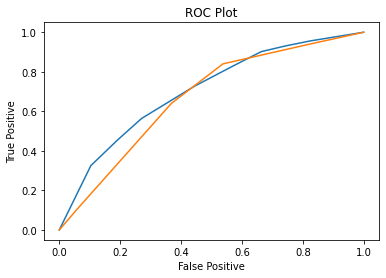

In [ ]:
# Test Set proportions
x=J48Training(LeagueGames,0.3,"gini","best",4,2,4,0.003)
printMetrics(x[0],x[1], x[2], x[3])

x=J48Training(LeagueGames,0.6,"gini","best",4,2,4,0.003)
printMetrics(x[0],x[1], x[2], x[3])

# TenFold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

def tenFoldTrain(data,s,crit,split,maxD,maxF,minL,ccpa,k):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  
  clf = DecisionTreeClassifier(criterion=crit, splitter=split,max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  scores = cross_val_score(clf, X_train, y_train, cv=k)

  return scores

#Unchanged Values
x=tenFoldTrain(LeagueGames,0.5,"gini","best",None,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.6225     0.645      0.61       0.6225     0.65       0.59649123
 0.5914787  0.61904762 0.58897243 0.63909774] 

Score Aver:   0.6185087719298246


In [ ]:
#Criterion

x=tenFoldTrain(LeagueGames,0.5,"entropy","best",3,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

x=tenFoldTrain(LeagueGames,0.5,"gini","best",3,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.735      0.74       0.7175     0.7375     0.69       0.71177945
 0.67418546 0.68421053 0.68421053 0.72932331] 

Score Aver:   0.7103709273182957
Scores:
 [0.7425     0.74       0.725      0.7375     0.6875     0.71177945
 0.67418546 0.68922306 0.68421053 0.72932331] 

Score Aver:   0.7121221804511279


In [ ]:
#Splitter test
x=tenFoldTrain(LeagueGames,0.5,"gini","best",4,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

x=tenFoldTrain(LeagueGames,0.5,"gini","random",4,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.735      0.74       0.7175     0.74       0.69       0.71929825
 0.67669173 0.68421053 0.68421053 0.73934837] 

Score Aver:   0.7126259398496242
Scores:
 [0.705      0.7375     0.7125     0.71       0.685      0.70676692
 0.6641604  0.67418546 0.66917293 0.73182957] 

Score Aver:   0.6996115288220551


In [ ]:
#Max epth
for x in range(2,6):
  print("FEATURES:  ",x)
  x=tenFoldTrain(LeagueGames,0.5,"gini","best",x,None,1,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

FEATURES:   2
Scores:
 [0.735      0.74       0.7175     0.74       0.69       0.71929825
 0.67669173 0.68421053 0.68421053 0.73934837] 

Score Aver:   0.7126259398496242 ]

FEATURES:   3
Scores:
 [0.7425     0.74       0.725      0.7375     0.6875     0.71177945
 0.67418546 0.68922306 0.68421053 0.72932331] 

Score Aver:   0.7121221804511279 ]

FEATURES:   4
Scores:
 [0.7325     0.7325     0.715      0.7325     0.695      0.70927318
 0.67418546 0.69423559 0.66917293 0.73182957] 

Score Aver:   0.7086196741854638 ]

FEATURES:   5
Scores:
 [0.705      0.715      0.715      0.7175     0.6875     0.70175439
 0.65413534 0.69172932 0.64661654 0.72681704] 

Score Aver:   0.6961052631578947 ]



In [ ]:
#Max Features
for x in range(2,6):
  print("FEATURES:  ",x)
  x=tenFoldTrain(LeagueGames,0.5,"gini","best",2,x,1,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

FEATURES:   2
Scores:
 [0.6475     0.615      0.5725     0.6075     0.6125     0.63909774
 0.58897243 0.58646617 0.61152882 0.60651629] 

Score Aver:   0.6087581453634086 ]

FEATURES:   3
Scores:
 [0.625      0.6575     0.6175     0.65       0.635      0.5839599
 0.61152882 0.58646617 0.62907268 0.6566416 ] 

Score Aver:   0.625266917293233 ]

FEATURES:   4
Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]

FEATURES:   5
Scores:
 [0.6975     0.7275     0.685      0.6975     0.68       0.6566416
 0.65413534 0.65162907 0.64160401 0.70426065] 

Score Aver:   0.6795770676691729 ]



In [ ]:
#Min Leaf
for x in range(2,7):
  print("Min leaf:",x,'\n')
  x=tenFoldTrain(LeagueGames,0.5,"gini","best",2,4,x,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

Min leaf: 2 

Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]

Min leaf: 3 

Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]

Min leaf: 4 

Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]

Min leaf: 5 

Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]

Min leaf: 6 

Scores:
 [0.68       0.6875     0.645      0.6725     0.6375     0.65413534
 0.66165414 0.62907268 0.64411028 0.69423559] 

Score Aver:   0.6605708020050124 ]



In [ ]:
#CCPA
deez = [0.001,0.002,0.003,0.004]
for x in deez:
  print("a:",x,'\n')
  x=tenFoldTrain(LeagueGames,0.5,"gini","best",4,4,2,x,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

a: 0.001 

Scores:
 [0.7        0.7225     0.6875     0.7175     0.6675     0.69172932
 0.65413534 0.63909774 0.67669173 0.70175439] 

Score Aver:   0.6858408521303258 ]

a: 0.002 

Scores:
 [0.7025     0.7225     0.7025     0.7175     0.6675     0.69172932
 0.65413534 0.63909774 0.66917293 0.70175439] 

Score Aver:   0.6868389724310777 ]

a: 0.003 

Scores:
 [0.7025     0.705      0.6975     0.695      0.665      0.6716792
 0.65413534 0.63909774 0.66917293 0.70676692] 

Score Aver:   0.6805852130325815 ]

a: 0.004 

Scores:
 [0.7025     0.705      0.6975     0.695      0.66       0.6716792
 0.66165414 0.63157895 0.66666667 0.71177945] 

Score Aver:   0.6803358395989976 ]



In [ ]:
#Folds
for x in range(2,11):
  print("splits ",x,'\n')
  x=tenFoldTrain(LeagueGames,0.5,"gini","best",4,4,2,0,x)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

splits  2 

Scores:
 [0.6956957  0.64897346] 

Score Aver:   0.6723345779429906 ]

splits  3 

Scores:
 [0.67867868 0.65915916 0.66566491] 

Score Aver:   0.6678342504788786 ]

splits  4 

Scores:
 [0.6956957  0.69369369 0.65865866 0.6503006 ] 

Score Aver:   0.6745871623126132 ]

splits  5 

Scores:
 [0.68961202 0.71214018 0.68210263 0.64705882 0.64831039] 

Score Aver:   0.6758448060075093 ]

splits  6 

Scores:
 [0.6966967  0.6981982  0.6951952  0.65165165 0.66366366 0.64210526] 

Score Aver:   0.6745851114272167 ]

splits  7 

Scores:
 [0.69001751 0.70402802 0.70402802 0.69176883 0.64798599 0.65964912
 0.67192982] 

Score Aver:   0.6813439026638399 ]

splits  8 

Scores:
 [0.694      0.718      0.718      0.67935872 0.68537074 0.65731463
 0.65130261 0.66933868] 

Score Aver:   0.6840856713426853 ]

splits  9 

Scores:
 [0.68018018 0.72072072 0.6981982  0.7027027  0.68243243 0.62387387
 0.66216216 0.66216216 0.68397291] 

Score Aver:   0.6796005938218128 ]

splits  10 

Scores:
 [0.

In [ ]:

x=tenFoldTrain(LeagueGames,0.3,"gini","best",4,4,2,0,None)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean(),"]\n")

x=tenFoldTrain(LeagueGames,0.6,"gini","best",4,4,2,0,None)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean(),"]\n")

Scores:
 [0.68961202 0.69461827 0.71276596 0.67334168 0.66249217] 

Score Aver:   0.6865660190454097 ]

Scores:
 [0.6703125  0.69483568 0.6056338  0.67762128 0.66666667] 

Score Aver:   0.6630139866979655 ]



# J48 Decision Tree on Training and Test

Number of mislabeled points out of a total 3995 points : 1463

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1997
           1       0.64      0.62      0.63      1998

    accuracy                           0.63      3995
   macro avg       0.63      0.63      0.63      3995
weighted avg       0.63      0.63      0.63      3995


True Positive: 1294 | False Negative: 703 | False Positive: 760 | True Negative: 1238

AUROC: 0.366204

____________________________________________________________________________________________


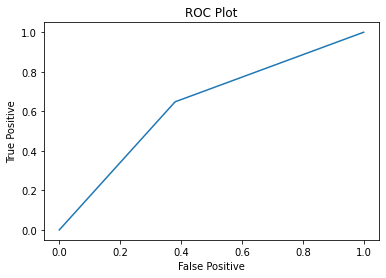

In [ ]:
def J48TrainTest(data,s,crit,split,maxD,maxF,minL,ccpa):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  
  tree_clf = DecisionTreeClassifier(criterion=crit, splitter=split,max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  treeFit = tree_clf.fit(X_train, y_train)
  y_pred = treeFit.predict(X_test)

  return [treeFit,X_test, y_test, y_pred]

#Default Settings
x=J48TrainTest(LeagueGames,0.5,"gini","best",None,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1170

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      1997
           1       0.69      0.74      0.72      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1347 | False Negative: 650 | False Positive: 520 | True Negative: 1478

AUROC: 0.220189

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1162

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1997
           1       0.68      0.78      0.73      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1275 |

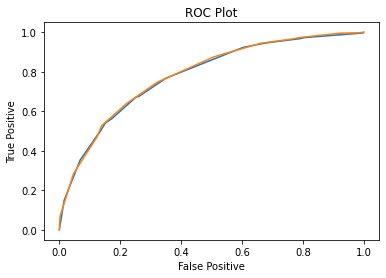

In [ ]:
#Criterion Test
x=J48TrainTest(LeagueGames,0.5,"gini","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48TrainTest(LeagueGames,0.5,"entropy","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1170

              precision    recall  f1-score   support

           0       0.72      0.67      0.70      1997
           1       0.69      0.74      0.72      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1347 | False Negative: 650 | False Positive: 520 | True Negative: 1478

AUROC: 0.220189

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1245

              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1997
           1       0.71      0.64      0.67      1998

    accuracy                           0.69      3995
   macro avg       0.69      0.69      0.69      3995
weighted avg       0.69      0.69      0.69      3995


True Positive: 1473 |

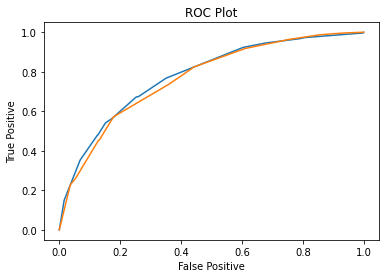

In [ ]:
x=J48TrainTest(LeagueGames,0.5,"gini","best",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48TrainTest(LeagueGames,0.5,"gini","random",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Depth: 2
Number of mislabeled points out of a total 3995 points : 1148

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1997
           1       0.73      0.68      0.70      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1493 | False Negative: 504 | False Positive: 644 | True Negative: 1354

AUROC: 0.230236

____________________________________________________________________________________________
Depth: 3
Number of mislabeled points out of a total 3995 points : 1158

              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1997
           1       0.69      0.77      0.73      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


Tru

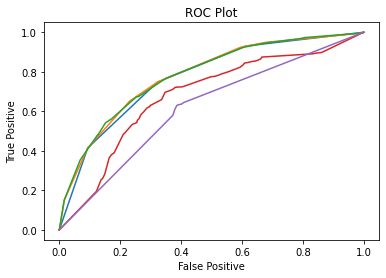

In [ ]:
#Max Depth
for x in range(2,5):
  print("Depth:",x)
  x=J48TrainTest(LeagueGames,0.5,"gini","best",x,None,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

x=J48TrainTest(LeagueGames,0.5,"gini","best",10,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48TrainTest(LeagueGames,0.5,"gini","best",20,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1506

              precision    recall  f1-score   support

           0       0.65      0.55      0.59      1997
           1       0.61      0.70      0.65      1998

    accuracy                           0.62      3995
   macro avg       0.63      0.62      0.62      3995
weighted avg       0.63      0.62      0.62      3995


True Positive: 1089 | False Negative: 908 | False Positive: 598 | True Negative: 1400

AUROC: 0.381717

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1541

              precision    recall  f1-score   support

           0       0.71      0.39      0.50      1997
           1       0.58      0.84      0.68      1998

    accuracy                           0.61      3995
   macro avg       0.64      0.61      0.59      3995
weighted avg       0.64      0.61      0.59      3995

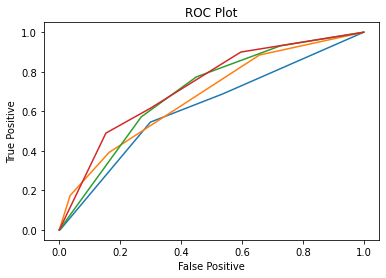

In [ ]:
#Max Features
for x in range(2,6):
  print("features:",x)
  x=J48TrainTest(LeagueGames,0.5,"gini","best",2,x,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1541

              precision    recall  f1-score   support

           0       0.71      0.39      0.50      1997
           1       0.58      0.84      0.68      1998

    accuracy                           0.61      3995
   macro avg       0.64      0.61      0.59      3995
weighted avg       0.64      0.61      0.59      3995


True Positive: 783 | False Negative: 1214 | False Positive: 327 | True Negative: 1671

AUROC: 0.322640

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1541

              precision    recall  f1-score   support

           0       0.71      0.39      0.50      1997
           1       0.58      0.84      0.68      1998

    accuracy                           0.61      3995
   macro avg       0.64      0.61      0.59      3995
weighted avg       0.64      0.61      0.59      3995

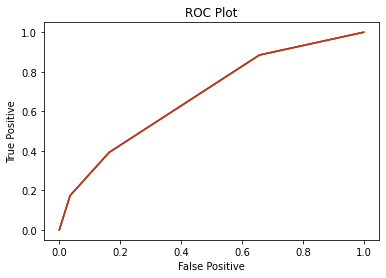

In [ ]:
#Leafs
for x in range(2,6):
  print("features:",x)
  x=J48TrainTest(LeagueGames,0.5,"gini","best",2,3,x,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

ccp:  0.001
Number of mislabeled points out of a total 3995 points : 1435

              precision    recall  f1-score   support

           0       0.61      0.79      0.69      1997
           1       0.70      0.49      0.58      1998

    accuracy                           0.64      3995
   macro avg       0.65      0.64      0.63      3995
weighted avg       0.65      0.64      0.63      3995


True Positive: 1573 | False Negative: 424 | False Positive: 1011 | True Negative: 987

AUROC: 0.297500

____________________________________________________________________________________________
ccp:  0.002
Number of mislabeled points out of a total 3995 points : 1470

              precision    recall  f1-score   support

           0       0.59      0.85      0.70      1997
           1       0.73      0.42      0.53      1998

    accuracy                           0.63      3995
   macro avg       0.66      0.63      0.61      3995
weighted avg       0.66      0.63      0.61      3995

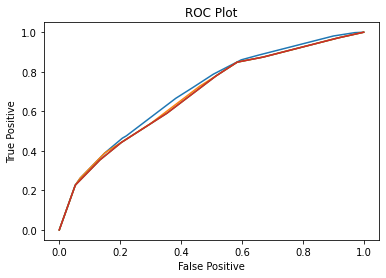

In [ ]:
#alpha
deez = [0.001,0.002,0.003,0.004]
for x in deez:
  print("ccp: ",x)
  x=J48TrainTest(LeagueGames,0.5,"gini","best",4,2,5,x)
  printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 2397 points : 827

              precision    recall  f1-score   support

           0       0.68      0.62      0.64      1217
           1       0.64      0.69      0.66      1180

    accuracy                           0.65      2397
   macro avg       0.66      0.66      0.65      2397
weighted avg       0.66      0.65      0.65      2397


True Positive: 751 | False Negative: 466 | False Positive: 361 | True Negative: 819

AUROC: 0.290419

____________________________________________________________________________________________
Number of mislabeled points out of a total 4794 points : 1761

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      2402
           1       0.63      0.65      0.64      2392

    accuracy                           0.63      4794
   macro avg       0.63      0.63      0.63      4794
weighted avg       0.63      0.63      0.63      4794


True Positive: 1480 | Fa

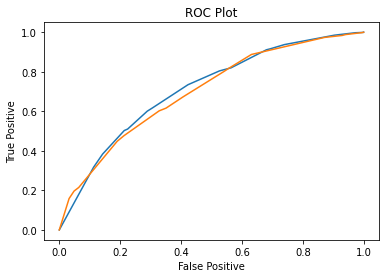

In [ ]:
x=J48TrainTest(LeagueGames,0.3,"gini","best",4,2,5,0)
printMetrics(x[0],x[1], x[2], x[3])

x=J48TrainTest(LeagueGames,0.6,"gini","best",4,2,5,0)
printMetrics(x[0],x[1], x[2], x[3])

# Random Forest on Training

Number of mislabeled points out of a total 3995 points : 0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1987
           1       1.00      1.00      1.00      2008

    accuracy                           1.00      3995
   macro avg       1.00      1.00      1.00      3995
weighted avg       1.00      1.00      1.00      3995


True Positive: 1987 | False Negative: 0 | False Positive: 0 | True Negative: 2008

AUROC: 0.000000

____________________________________________________________________________________________


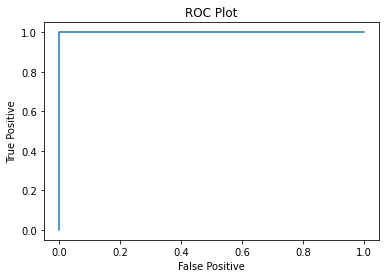

In [ ]:
from sklearn import tree
def randomForestTraining(data,s,crit,maxD,maxF,minL,ccpa):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  
  tree_clf = RandomForestClassifier(criterion=crit, max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  treeFit = tree_clf.fit(X_train, y_train)
  y_pred = treeFit.predict(X_train)
  
  return [treeFit,X_train, y_train, y_pred]

#THIS is a default tree
x=randomForestTraining(LeagueGames,0.5,"gini",None,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1087

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1987
           1       0.73      0.73      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995


True Positive: 1441 | False Negative: 546 | False Positive: 541 | True Negative: 1467

AUROC: 0.186352

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1095

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1987
           1       0.73      0.73      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995


True Positive: 1437 |

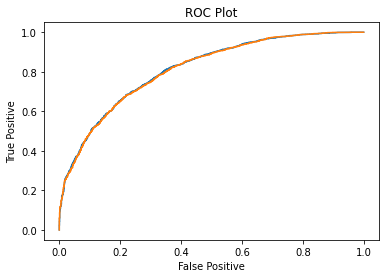

In [ ]:
#Criterion Test
x=randomForestTraining(LeagueGames,0.5,"gini",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTraining(LeagueGames,0.5,"entropy",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Depth: 2
Number of mislabeled points out of a total 3995 points : 1141

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1987
           1       0.73      0.68      0.71      2008

    accuracy                           0.71      3995
   macro avg       0.72      0.71      0.71      3995
weighted avg       0.72      0.71      0.71      3995


True Positive: 1483 | False Negative: 504 | False Positive: 637 | True Negative: 1371

AUROC: 0.210885

____________________________________________________________________________________________
Depth: 3
Number of mislabeled points out of a total 3995 points : 1112

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1987
           1       0.73      0.72      0.72      2008

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


Tru

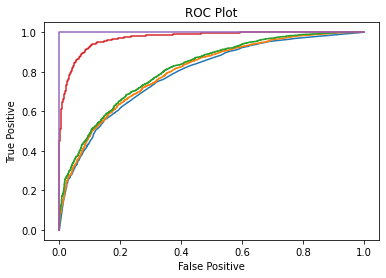

In [ ]:
#Max Depth
for x in range(2,5):
  print("Depth:",x)
  x=randomForestTraining(LeagueGames,0.5,"gini",x,None,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTraining(LeagueGames,0.5,"gini",10,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTraining(LeagueGames,0.5,"gini",20,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1090

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1987
           1       0.72      0.74      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995


True Positive: 1423 | False Negative: 564 | False Positive: 526 | True Negative: 1482

AUROC: 0.206963

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1110

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1987
           1       0.72      0.74      0.73      2008

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995

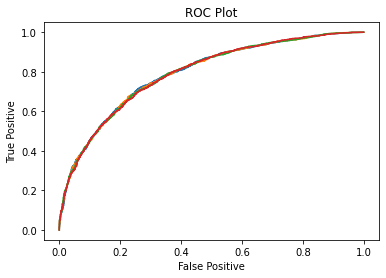

In [ ]:
#Max Features
for x in range(2,6):
  print("features:",x)
  x=randomForestTraining(LeagueGames,0.5,"gini",2,x,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1090

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1987
           1       0.72      0.74      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995


True Positive: 1423 | False Negative: 564 | False Positive: 526 | True Negative: 1482

AUROC: 0.206968

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1090

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1987
           1       0.72      0.74      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995

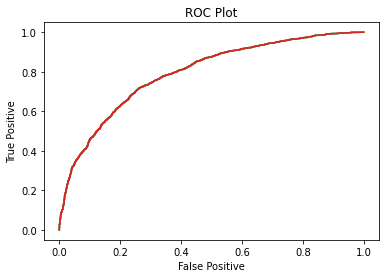

In [ ]:
#min leaves
for x in range(2,6):
  print("features:",x)
  x=randomForestTraining(LeagueGames,0.5,"gini",2,2,x,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 5593 points : 1539

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      2767
           1       0.73      0.72      0.73      2826

    accuracy                           0.72      5593
   macro avg       0.72      0.72      0.72      5593
weighted avg       0.72      0.72      0.72      5593


True Positive: 2009 | False Negative: 758 | False Positive: 781 | True Negative: 2045

AUROC: 0.206234

____________________________________________________________________________________________
Number of mislabeled points out of a total 3196 points : 907

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1582
           1       0.71      0.73      0.72      1614

    accuracy                           0.72      3196
   macro avg       0.72      0.72      0.72      3196
weighted avg       0.72      0.72      0.72      3196


True Positive: 1105 | 

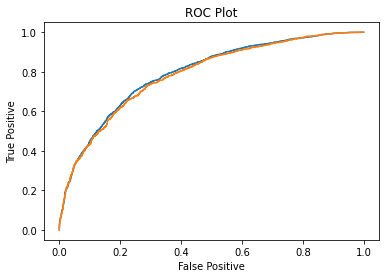

In [ ]:
x=randomForestTraining(LeagueGames,0.3,"gini",2,2,4,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTraining(LeagueGames,0.6,"gini",2,2,4,0.0)
printMetrics(x[0],x[1], x[2], x[3])

ccp:  0.001
Number of mislabeled points out of a total 3995 points : 1078

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1987
           1       0.73      0.74      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995


True Positive: 1430 | False Negative: 557 | False Positive: 521 | True Negative: 1487

AUROC: 0.193344

____________________________________________________________________________________________
ccp:  0.002
Number of mislabeled points out of a total 3995 points : 1076

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1987
           1       0.73      0.74      0.73      2008

    accuracy                           0.73      3995
   macro avg       0.73      0.73      0.73      3995
weighted avg       0.73      0.73      0.73      3995

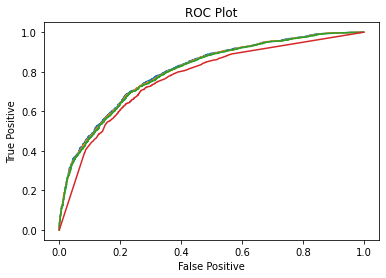

In [ ]:
#alpha
deez = [0.001,0.002,0.003,0.06]
for x in deez:
  print("ccp: ", x)
  x=randomForestTraining(LeagueGames,0.5,"gini",4,2,4,x)
  printMetrics(x[0],x[1], x[2], x[3])

# Ten Fold Cross Validation Random Forest

In [ ]:
def tenFoldForest(data,s,crit,maxD,maxF,minL,ccpa,k):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)

  clf = RandomForestClassifier(criterion=crit,max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  scores = cross_val_score(clf, X_train, y_train, cv=k)

  return scores

#Unchanged Values
x=tenFoldForest(LeagueGames,0.5,"gini",None,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.73       0.7075     0.705      0.7225     0.705      0.70426065
 0.64661654 0.67418546 0.6716792  0.71679198] 

Score Aver:   0.6983533834586466


In [ ]:
#Crit

x=tenFoldForest(LeagueGames,0.5,"entropy",3,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

x=tenFoldForest(LeagueGames,0.5,"gini",3,None,1,0.0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.7375     0.745      0.725      0.7275     0.69       0.72932331
 0.68421053 0.69172932 0.69172932 0.73934837] 

Score Aver:   0.7161340852130325
Scores:
 [0.735      0.745      0.73       0.7325     0.6925     0.72932331
 0.68671679 0.68922306 0.68922306 0.73934837] 

Score Aver:   0.7168834586466165


In [ ]:
#Max Features
for x in range(2,6):
  print("FEATURES:  ",x)
  x=tenFoldForest(LeagueGames,0.5,"gini",4,x,1,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

FEATURES:   2
Scores:
 [0.735      0.7475     0.715      0.73       0.6875     0.74686717
 0.68421053 0.68671679 0.69674185 0.73934837] 

Score Aver:   0.7168884711779449 ]

FEATURES:   3
Scores:
 [0.7425     0.7475     0.72       0.7375     0.6825     0.72681704
 0.67669173 0.67919799 0.69674185 0.74686717] 

Score Aver:   0.7156315789473684 ]

FEATURES:   4
Scores:
 [0.7475     0.745      0.7175     0.7375     0.6925     0.73934837
 0.68170426 0.67919799 0.69423559 0.74185464] 

Score Aver:   0.7176340852130325 ]

FEATURES:   5
Scores:
 [0.74       0.745      0.7225     0.7375     0.6925     0.7443609
 0.68170426 0.68421053 0.68671679 0.74937343] 

Score Aver:   0.7183865914786968 ]



In [ ]:
#Features
for x in range(2,7):
  print("Min leaf:",x,'\n')
  x=tenFoldForest(LeagueGames,0.5,"gini",2,x,1,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

Min leaf: 2 

Scores:
 [0.7425     0.745      0.72       0.73       0.675      0.74686717
 0.6716792  0.68421053 0.68671679 0.74937343] 

Score Aver:   0.7151347117794487 ]

Min leaf: 3 

Scores:
 [0.7375     0.75       0.7275     0.73       0.6775     0.73182957
 0.68421053 0.67669173 0.68671679 0.73684211] 

Score Aver:   0.7138790726817043 ]

Min leaf: 4 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]

Min leaf: 5 

Scores:
 [0.73       0.7475     0.72       0.7375     0.6825     0.72681704
 0.68170426 0.66917293 0.68421053 0.73684211] 

Score Aver:   0.711624686716792 ]

Min leaf: 6 

Scores:
 [0.725      0.7475     0.7175     0.735      0.6775     0.72932331
 0.67669173 0.66666667 0.67919799 0.74686717] 

Score Aver:   0.7101246867167921 ]



In [ ]:
#Min Leaf
for x in range(2,7):
  print("Min leaf:",x,'\n')
  x=tenFoldForest(LeagueGames,0.5,"gini",2,2,x,0.0,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

Min leaf: 2 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]

Min leaf: 3 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]

Min leaf: 4 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]

Min leaf: 5 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]

Min leaf: 6 

Scores:
 [0.7375     0.745      0.72       0.7325     0.6775     0.72431078
 0.6716792  0.67418546 0.67919799 0.7443609 ] 

Score Aver:   0.71062343358396 ]



In [ ]:
#CCPA
deez = [0.001,0.002,0.003,0.004]
for x in deez:
  print("a:",x,'\n')
  x=tenFoldForest(LeagueGames,0.5,"gini",4,2,6,x,10)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

a: 0.001 

Scores:
 [0.735      0.7475     0.7225     0.735      0.6825     0.7443609
 0.67919799 0.68922306 0.69924812 0.73684211] 

Score Aver:   0.7171372180451128 ]

a: 0.002 

Scores:
 [0.7375     0.745      0.725      0.7325     0.6775     0.74185464
 0.67669173 0.69172932 0.69423559 0.73684211] 

Score Aver:   0.7158853383458645 ]

a: 0.003 

Scores:
 [0.7375     0.745      0.725      0.7325     0.675      0.74686717
 0.67919799 0.69172932 0.69172932 0.73934837] 

Score Aver:   0.7163872180451127 ]

a: 0.004 

Scores:
 [0.74       0.745      0.725      0.735      0.675      0.74185464
 0.67919799 0.68671679 0.69172932 0.74185464] 

Score Aver:   0.7161353383458646 ]



In [ ]:
x=tenFoldForest(LeagueGames,0.3,"gini",4,2,6,0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean(),"]\n")

x=tenFoldForest(LeagueGames,0.6,"gini",4,2,6,0,10)
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean(),"]\n")

Scores:
 [0.71964286 0.7125     0.75714286 0.74418605 0.73345259 0.72629696
 0.71198569 0.69946333 0.69946333 0.71914132] 

Score Aver:   0.7223274980833121 ]

Scores:
 [0.728125   0.715625   0.75       0.6875     0.74375    0.66875
 0.70846395 0.70846395 0.70219436 0.73981191] 

Score Aver:   0.7152684169278998 ]



In [ ]:
#Folds
for x in range(2,11):
  print("splits ",x,'\n')
  x=tenFoldForest(LeagueGames,0.5,"gini",4,4,2,0,x)
  print("Scores:\n",x,"\n")
  print("Score Aver:"," ",x.mean(),"]\n")

splits  2 

Scores:
 [0.72322322 0.70105158] 

Score Aver:   0.7121374002946361 ]

splits  3 

Scores:
 [0.73348348 0.70720721 0.70848986] 

Score Aver:   0.7163935159802929 ]

splits  4 

Scores:
 [0.74174174 0.70970971 0.70770771 0.70641283] 

Score Aver:   0.7163929962026154 ]

splits  5 

Scores:
 [0.74092616 0.72841051 0.7146433  0.67334168 0.72215269] 

Score Aver:   0.7158948685857323 ]

splits  6 

Scores:
 [0.74324324 0.72522523 0.71171171 0.7042042  0.7042042  0.71729323] 

Score Aver:   0.7176469702785492 ]

splits  7 

Scores:
 [0.74430823 0.73204904 0.72854641 0.71278459 0.69352014 0.6877193
 0.72105263] 

Score Aver:   0.71714004801847 ]

splits  8 

Scores:
 [0.742      0.74       0.714      0.70741483 0.71943888 0.69338677
 0.68537074 0.72745491] 

Score Aver:   0.7161332665330662 ]

splits  9 

Scores:
 [0.73423423 0.75675676 0.71846847 0.73423423 0.70720721 0.68243243
 0.68918919 0.69594595 0.73137698] 

Score Aver:   0.7166494937375298 ]

splits  10 

Scores:
 [0.75 

# Random Forest on Training and Test

Number of mislabeled points out of a total 3995 points : 1164

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1997
           1       0.71      0.70      0.71      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1430 | False Negative: 567 | False Positive: 597 | True Negative: 1401

AUROC: 0.223528

____________________________________________________________________________________________


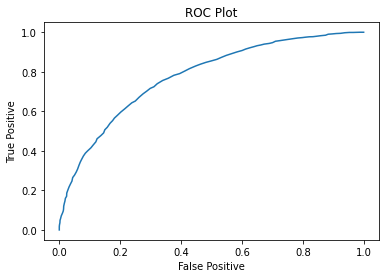

In [ ]:
from sklearn import tree
def randomForestTrainingTest(data,s,crit,maxD,maxF,minL,ccpa):
  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  
  tree_clf = RandomForestClassifier(criterion=crit, max_depth=maxD,max_features=maxF,
                                    min_samples_leaf = minL,random_state=42,ccp_alpha = ccpa)
  
  treeFit = tree_clf.fit(X_train, y_train)
  y_pred = treeFit.predict(X_test)
  
  return [treeFit,X_test, y_test, y_pred]

#THIS is a default tree
x=randomForestTrainingTest(LeagueGames,0.5,"gini",None,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 3995 points : 1119

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.72      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1424 | False Negative: 573 | False Positive: 546 | True Negative: 1452

AUROC: 0.205830

____________________________________________________________________________________________
Number of mislabeled points out of a total 3995 points : 1123

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.72      0.72      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1425 |

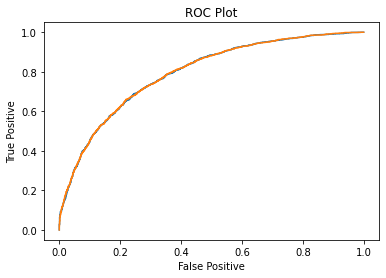

In [ ]:
#Criterion Test
x=randomForestTrainingTest(LeagueGames,0.5,"gini",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTrainingTest(LeagueGames,0.5,"entropy",4,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

Depth: 2
Number of mislabeled points out of a total 3995 points : 1148

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1997
           1       0.73      0.68      0.70      1998

    accuracy                           0.71      3995
   macro avg       0.71      0.71      0.71      3995
weighted avg       0.71      0.71      0.71      3995


True Positive: 1493 | False Negative: 504 | False Positive: 644 | True Negative: 1354

AUROC: 0.211920

____________________________________________________________________________________________
Depth: 3
Number of mislabeled points out of a total 3995 points : 1132

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1997
           1       0.72      0.72      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


Tru

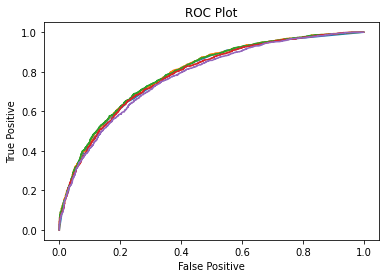

In [ ]:
#Max Depth
for x in range(2,5):
  print("Depth:",x)
  x=randomForestTrainingTest(LeagueGames,0.5,"gini",x,None,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTrainingTest(LeagueGames,0.5,"gini",10,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

x=randomForestTrainingTest(LeagueGames,0.5,"gini",20,None,1,0.0)
printMetrics(x[0],x[1], x[2], x[3])

features: 2
Number of mislabeled points out of a total 3995 points : 1124

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.71      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1414 | False Negative: 583 | False Positive: 541 | True Negative: 1457

AUROC: 0.208490

____________________________________________________________________________________________
features: 3
Number of mislabeled points out of a total 3995 points : 1123

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.72      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995

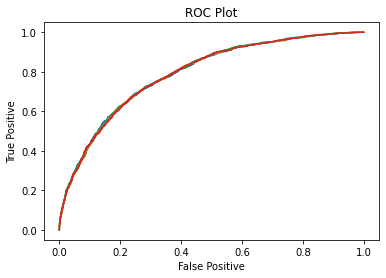

In [ ]:
#Max Features
for x in range(2,6):
  print("features:",x)
  x=randomForestTrainingTest(LeagueGames,0.5,"gini",2,x,1,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

leaff: 2
Number of mislabeled points out of a total 3995 points : 1124

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.71      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1414 | False Negative: 583 | False Positive: 541 | True Negative: 1457

AUROC: 0.208492

____________________________________________________________________________________________
leaff: 3
Number of mislabeled points out of a total 3995 points : 1124

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.71      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


Tru

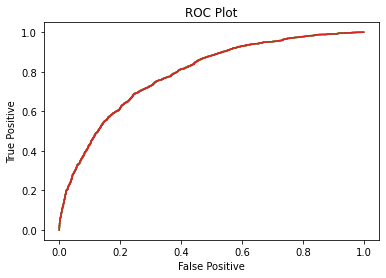

In [ ]:
#Leaf
for x in range(2,6):
  print("leaff:",x)
  x=randomForestTrainingTest(LeagueGames,0.5,"gini",2,2,x,0.0)
  printMetrics(x[0],x[1], x[2], x[3])

ccp:  0.001
Number of mislabeled points out of a total 3995 points : 1117

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1997
           1       0.72      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995


True Positive: 1418 | False Negative: 579 | False Positive: 538 | True Negative: 1460

AUROC: 0.206512

____________________________________________________________________________________________
ccp:  0.002
Number of mislabeled points out of a total 3995 points : 1118

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1997
           1       0.72      0.73      0.72      1998

    accuracy                           0.72      3995
   macro avg       0.72      0.72      0.72      3995
weighted avg       0.72      0.72      0.72      3995

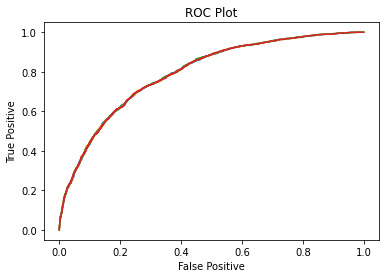

In [ ]:
#alpha
deez = [0.001,0.002,0.003,0.004]
for x in deez:
  print("ccp: ",x)
  x=randomForestTrainingTest(LeagueGames,0.5,"gini",4,2,6,x)
  printMetrics(x[0],x[1], x[2], x[3])

Number of mislabeled points out of a total 2397 points : 690

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 866 | False Negative: 351 | False Positive: 339 | True Negative: 841

AUROC: 0.209699

____________________________________________________________________________________________
Number of mislabeled points out of a total 4794 points : 1317

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2402
           1       0.72      0.72      0.72      2392

    accuracy                           0.73      4794
   macro avg       0.73      0.73      0.73      4794
weighted avg       0.73      0.73      0.73      4794


True Positive: 1745 | Fa

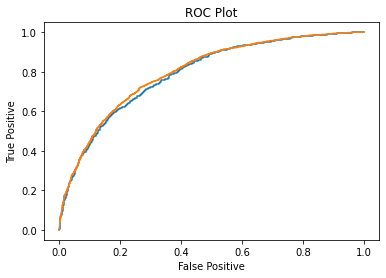

In [ ]:
x=randomForestTrainingTest(LeagueGames,0.3,"gini",4,2,6,0)
printMetrics(x[0],x[1],x[2],x[3])

x=randomForestTrainingTest(LeagueGames,0.6,"gini",4,2,6,0)
printMetrics(x[0],x[1],x[2],x[3])

# Linear Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#return the split
def returnTrainingTest(data,s):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=s, random_state=0)
  return [X_train, X_test, y_train, y_test]

from sklearn.linear_model import SGDClassifier
def linearRegressor(data,s):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  clf = SGDClassifier(loss="log", max_iter=5)

  if s==0:
    X_train = X
    y_train = Y
    Fit = clf.fit(X_train, y_train)
    y_pred = Fit.predict(X_train)
    return [Fit,X_train, y_train, y_pred]

  else:
    X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
    Fit = clf.fit(X_train, y_train)
    y_pred = Fit.predict(X_test)
    return [Fit,X_test, y_test, y_pred]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Number of mislabeled points out of a total 7990 points : 2465

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      3984
           1       0.72      0.62      0.67      4006

    accuracy                           0.69      7990
   macro avg       0.70      0.69      0.69      7990
weighted avg       0.70      0.69      0.69      7990


True Positive: 3035 | False Negative: 949 | False Positive: 1516 | True Negative: 2490

AUROC: 0.233649

____________________________________________________________________________________________


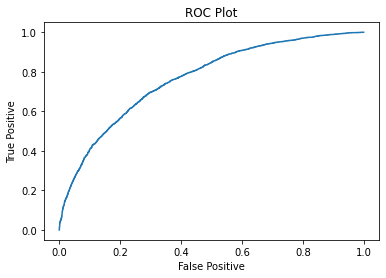

In [ ]:
x=linearRegressor(LeagueGames,0)
printMetrics(x[0],x[1], x[2], x[3])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 887

              precision    recall  f1-score   support

           0       0.66      0.56      0.61      1217
           1       0.61      0.70      0.65      1180

    accuracy                           0.63      2397
   macro avg       0.63      0.63      0.63      2397
weighted avg       0.63      0.63      0.63      2397


True Positive: 686 | False Negative: 531 | False Positive: 356 | True Negative: 824

AUROC: 0.313029

____________________________________________________________________________________________


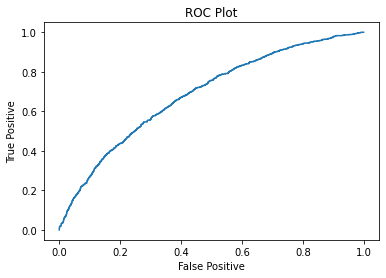

In [ ]:
x=linearRegressor(LeagueGames,0.3)
printMetrics(x[0],x[1], x[2], x[3])

# TenFold

In [ ]:
from sklearn.linear_model import SGDClassifier
def linearRegressor10(data,s, foldsfat):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']

  clf = SGDClassifier(loss="log", max_iter=10)

  if s==0:
    X_train = X
    y_train = Y
    Fit = clf.fit(X_train, y_train)
    y_pred = Fit.predict(X_train)
    scores = cross_val_score(clf, X_train, y_train, cv=foldsfat)
    return scores

  else:
    X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
    Fit = clf.fit(X_train, y_train)
    y_pred = Fit.predict(X_test)
    scores = cross_val_score(clf, X_test, y_test, cv=foldsfat)
    return scores

In [ ]:
x=linearRegressor10(LeagueGames,0,10)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

In [ ]:
print("Scores:\n",x,"\n")
print("Score Aver:"," ",x.mean())

Scores:
 [0.71714643 0.69336671 0.7008761  0.58072591 0.64831039 0.65206508
 0.6583229  0.65707134 0.70838548 0.66082603] 

Score Aver:   0.6677096370463078


In [ ]:
x=linearRegressor10(LeagueGames,0.3,10)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

In [ ]:
print("Scores:",x)
print("Score:: ", x.mean())

Scores: [0.60416667 0.6        0.69166667 0.62916667 0.64166667 0.63333333
 0.55       0.64435146 0.63179916 0.48117155]
Score::  0.6107322175732218


# MultiLayer

In [ ]:
from sklearn.neural_network import MLPClassifier
def mlp(data,s,activation,hiddenLayerSize,learnin,epoch,momentum,threshold):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']
  maxter=epoch
  clf = MLPClassifier(random_state=42, max_iter=maxter,hidden_layer_sizes=hiddenLayerSize,activation=activation
                      ,learning_rate=learnin,momentum=momentum,n_iter_no_change=threshold)

  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  Fit = clf.fit(X_train, y_train)
  y_pred = Fit.predict(X_test)
  return [Fit,X_test, y_test, y_pred]

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 720

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1217
           1       0.69      0.71      0.70      1180

    accuracy                           0.70      2397
   macro avg       0.70      0.70      0.70      2397
weighted avg       0.70      0.70      0.70      2397


True Positive: 836 | False Negative: 381 | False Positive: 339 | True Negative: 841

AUROC: 0.244498

____________________________________________________________________________________________


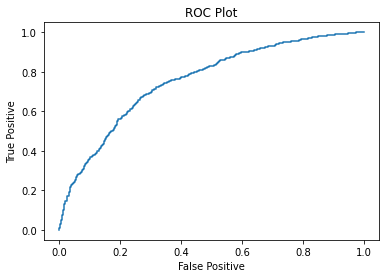

In [ ]:
#Default
mlpee=mlp(LeagueGames,0.3,'relu',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

Identity

Number of mislabeled points out of a total 2397 points : 700

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1217
           1       0.70      0.71      0.70      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 864 | False Negative: 353 | False Positive: 347 | True Negative: 833

AUROC: 0.209970

____________________________________________________________________________________________
Tanh



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 767

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1217
           1       0.68      0.67      0.67      1180

    accuracy                           0.68      2397
   macro avg       0.68      0.68      0.68      2397
weighted avg       0.68      0.68      0.68      2397


True Positive: 837 | False Negative: 380 | False Positive: 387 | True Negative: 793

AUROC: 0.258020

____________________________________________________________________________________________
Relu



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 720

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1217
           1       0.69      0.71      0.70      1180

    accuracy                           0.70      2397
   macro avg       0.70      0.70      0.70      2397
weighted avg       0.70      0.70      0.70      2397


True Positive: 836 | False Negative: 381 | False Positive: 339 | True Negative: 841

AUROC: 0.244498

____________________________________________________________________________________________
Logs

Number of mislabeled points out of a total 2397 points : 686

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.72      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 862 

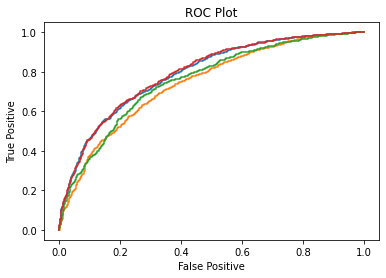

In [ ]:
#Function

print("Identity\n")
mlpee=mlp(LeagueGames,0.3,'identity',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("Tanh\n")
mlpee=mlp(LeagueGames,0.3,'tanh',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("Relu\n")
mlpee=mlp(LeagueGames,0.3,'relu',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("Logs\n")
mlpee=mlp(LeagueGames,0.3,'logistic',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

20

Number of mislabeled points out of a total 2397 points : 689

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 865 | False Negative: 352 | False Positive: 337 | True Negative: 843

AUROC: 0.206108

____________________________________________________________________________________________
50

Number of mislabeled points out of a total 2397 points : 688

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 87

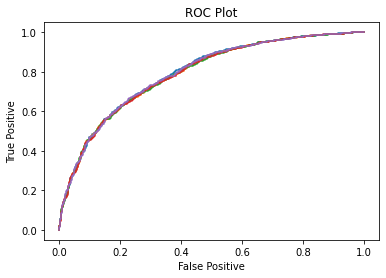

In [ ]:
#Layers
print("20\n")
mlpee=mlp(LeagueGames,0.3,'identity',(20,20),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("50\n")
mlpee=mlp(LeagueGames,0.3,'identity',(50,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("100\n")
mlpee=mlp(LeagueGames,0.3,'identity',(100,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("20\n")
mlpee=mlp(LeagueGames,0.3,'identity',(200,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print("400\n")
mlpee=mlp(LeagueGames,0.3,'identity',(400,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

adap adaptaation
Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | False Negative: 343 | False Positive: 344 | True Negative: 836

AUROC: 0.206394

____________________________________________________________________________________________
inv
Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True

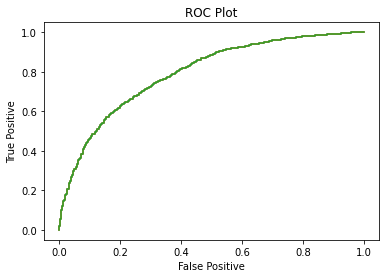

In [ ]:
print("adap adaptaation")
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print("inv")
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'invscaling',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print("constant\n")
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

Max Iteration
10
Number of mislabeled points out of a total 2397 points : 694

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 871 | False Negative: 346 | False Positive: 348 | True Negative: 832

AUROC: 0.209342

____________________________________________________________________________________________
20


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 688

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.72      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 864 | False Negative: 353 | False Positive: 335 | True Negative: 845

AUROC: 0.207517

____________________________________________________________________________________________
40


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 680

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.72      0.71      1180

    accuracy                           0.72      2397
   macro avg       0.72      0.72      0.72      2397
weighted avg       0.72      0.72      0.72      2397


True Positive: 869 | False Negative: 348 | False Positive: 332 | True Negative: 848

AUROC: 0.205828

____________________________________________________________________________________________
80
Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | F

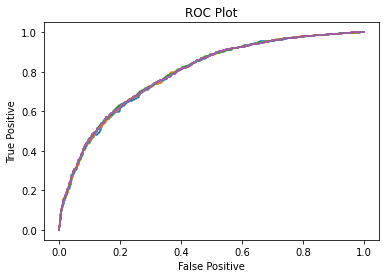

In [ ]:
print("Max Iteration")
print(10)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',10,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print(20)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print(40)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',40,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print(80)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',80,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])
print(100)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',160,0.9,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

0.4


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | False Negative: 343 | False Positive: 344 | True Negative: 836

AUROC: 0.206394

____________________________________________________________________________________________
0.5


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | False Negative: 343 | False Positive: 344 | True Negative: 836

AUROC: 0.206394

____________________________________________________________________________________________
0.6


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | False Negative: 343 | False Positive: 344 | True Negative: 836

AUROC: 0.206394

____________________________________________________________________________________________
0.7


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 874 | False Negative: 343 | False Positive: 344 | True Negative: 836

AUROC: 0.206394

____________________________________________________________________________________________
0.8


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Number of mislabeled points out of a total 2397 points : 688

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.72      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 864 | False Negative: 353 | False Positive: 335 | True Negative: 845

AUROC: 0.207517

____________________________________________________________________________________________


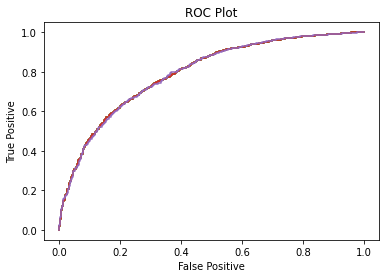

In [ ]:
def mlpens(data,s,activation,hiddenLayerSize,learnin,epoch,momentum,threshold):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']
  maxter=epoch
  clf = MLPClassifier(random_state=42, solver='sgd', max_iter=maxter,hidden_layer_sizes=hiddenLayerSize,activation=activation
                      ,learning_rate=learnin,momentum=momentum,n_iter_no_change=threshold)

  X_train, X_test, y_train, y_test = returnTrainingTest(data,s)
  Fit = clf.fit(X_train, y_train)
  y_pred = Fit.predict(X_test)
  return [Fit,X_test, y_test, y_pred]

print(0.4)
mlpens=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.4,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print(0.5)
mlpens=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.5,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print(0.6)
mlpens=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.6,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print(0.7)
mlpens=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.7,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

print(0.8)
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'adaptive',20,0.8,10)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])


Number of mislabeled points out of a total 2397 points : 687

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1217
           1       0.71      0.71      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 873 | False Negative: 344 | False Positive: 343 | True Negative: 837

AUROC: 0.206657

____________________________________________________________________________________________
Number of mislabeled points out of a total 2397 points : 685

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      1217
           1       0.71      0.72      0.71      1180

    accuracy                           0.71      2397
   macro avg       0.71      0.71      0.71      2397
weighted avg       0.71      0.71      0.71      2397


True Positive: 868 | Fals

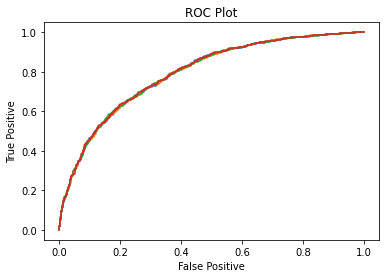

In [ ]:
mlpee=mlp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,4)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

mlpee=mlp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,2)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

mlpee=mlp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,6)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])

mlpee=mlp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,8)
printMetrics(mlpee[0],mlpee[1], mlpee[2], mlpee[3])


In [ ]:
def deezMLp(data,s,activation,hiddenLayerSize,learnin,epoch,momentum,threshold,eeeeee):
  X = data.drop('blueWins', 1)
  Y = data['blueWins']
  maxter=epoch
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=s, random_state=0)
  clf = MLPClassifier(random_state=42, max_iter=maxter,hidden_layer_sizes=hiddenLayerSize,activation=activation
                      ,learning_rate=learnin,momentum=momentum,n_iter_no_change=threshold)
  scores = cross_val_score(clf, X_test, y_test, cv=eeeeee)
  return scores

mlpee=deezMLp(LeagueGames,0.3,'identity',(20,),'constant',200,0.9,6,10)
print(mlpee.mean())

0.7125819386331939
